In [1]:
pwd

u'/Users/linzeyang'

In [2]:
cd Desktop/BIA-660/Final Project/data

/Users/linzeyang/Desktop/BIA-660/Final Project/data


### Increasing rate of Cumulative trip since 2015 becomes small, we consider it plateaued

so, I used 2015,2016 data for training, and 2017 for testing.
More specific, I trained data by season, so for each season there are 3 (month/year) * 2 (year) = 6 months
For later testing, you only need to identify which season it belongs to.

In [3]:
# glob.glob("2016*.csv")

In [71]:
# all_data = pd.DataFrame()
# for f in glob.glob("2016*.csv"):
#     df = pd.read_csv(f)
#     all_data = all_data.append(df,ignore_index=True)

In [78]:
#del all_data['Birth Year']
#del all_data['User Type']
#del all_data['Gender']

In [3]:
import pandas as pd
import numpy as np
import re
import datetime
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from six.moves import urllib
import json
import collections
import itertools
import requests
import time
import pandas as pd
from  __builtin__ import any as b_any
import math
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
%matplotlib inline


/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Integrate Variables & Data Preprocess

In [48]:
# =========== Pre-process ==========
df = pd.read_csv('201612-citibike-tripdata.csv')
#df = pd.read_csv('201608-citibike-tripdata.csv')
#df = all_data
# Missing values in columns
#print(df.isnull().sum())
# Snake_case the columns
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).replace(' ','').lower()
df.columns = [camel_to_snake(col) for col in df.columns]

# Parse start_time and stop_time
try:
    df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df.start_time]
#except ValueError:
    #df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M') for x in df.start_time]
except ValueError:
     df['start_datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df.start_time]
df['start_day'] = [x.strftime('%Y-%m-%d') for x in df.start_datetime]

# =========== Group by date and station ===========
df['bikein'] = 1
df['bikeout'] = 1

df_bikeout = df.groupby(by=['start_stationid', 'start_day'])['bikeout'].count()
df_bikeout = pd.DataFrame(df_bikeout)
df_out = df_bikeout.reset_index(drop = False)
df_out.rename_axis({'start_stationid':'station_id'}, axis='columns', inplace=True)
print(df_out.head())

df_bikein = df.groupby(by=['end_stationid', 'start_day'])['bikein'].count()
df_bikein = pd.DataFrame(df_bikein)
df_in = df_bikein.reset_index(drop = False)
df_in.rename_axis({'end_stationid':'station_id'}, axis='columns', inplace=True)
#print(df_in.head())


# =========== Bike loss per day for each station ===========
# Merge two DFs by station_id
df_dayloss = df_out.merge(right=df_in, left_on=['station_id', 'start_day'], right_on=['station_id', 'start_day'],
                          how='outer')
df_dayloss = df_dayloss.sort_values(['station_id', 'start_day'])
df_dayloss = df_dayloss.fillna(0)
df_dayloss['bike_loss'] = df_dayloss['bikeout'] - df_dayloss['bikein']
print(df_dayloss[1:5])


   station_id   start_day  bikeout
0          72  2016-12-01      100
1          72  2016-12-02       92
2          72  2016-12-03       53
3          72  2016-12-04       47
4          72  2016-12-05       78
   station_id   start_day  bikeout  bikein  bike_loss
1          72  2016-12-02     92.0    85.0        7.0
2          72  2016-12-03     53.0    50.0        3.0
3          72  2016-12-04     47.0    60.0      -13.0
4          72  2016-12-05     78.0    62.0       16.0


In [49]:
df_dayloss[df_dayloss.station_id==72][1:5]

,station_id,start_day,bikeout,bikein,bike_loss
1,72,2016-12-02,92.0,85.0,7.0
2,72,2016-12-03,53.0,50.0,3.0
3,72,2016-12-04,47.0,60.0,-13.0
4,72,2016-12-05,78.0,62.0,16.0


In [50]:
# append weekday_index column
#wekday_name=pd.to_datetime(df_dayloss.start_day).dt.weekday_name   #name
df_wekday_index=pd.to_datetime(df_dayloss.start_day).dt.weekday   # index Monday=0, Sunday=6
# Append weekday column to df_dayloss
df_dayloss['wek_index']=df_wekday_index


In [51]:
# =========== count docks Then append to dayloss============
jsonurl = urllib.request.urlopen('https://gbfs.citibikenyc.com/gbfs/en/station_status.json')
text = json.loads(jsonurl.read()) # <-- read from it
data=text['data']
#print(len(data['stations']))   664 stations
#print(data['stations'][0]['station_id']) # station id

# station id Extract:
total_stations_id = []
for i in range(len(data['stations'])):
    id=data['stations'][i]['station_id']
    total_stations_id.append(id)
total_stations_id=[int(x) for x in total_stations_id]
#print('station_id list:'+str(total_stations_id))

# num_bikes_available Extract:
total_num_bikes_available = []
for i in range(len(data['stations'])):
    num_bikes_available = data['stations'][i]['num_bikes_available']
    total_num_bikes_available.append(num_bikes_available)
#print('bikes availble:'+str(total_num_bikes_available))

# num_docks_available Extract:
total_docks_available = []
for i in range(len(data['stations'])):
    docks_availble=data['stations'][i]['num_docks_available']
    total_docks_available.append(docks_availble)
#print('docks availble:'+str(total_docks_available))

total_docks=[x + y for x, y in zip(total_num_bikes_available, total_docks_available)]
#print('total docks for each station:'+str(total_docks))
#to_dict

new_dict = dict(zip(total_stations_id,total_docks))
#print('zip station_id and total docks:'+str(new_dict))

# append docks to df_dayloss
df_dayloss['docks'] = df_dayloss['station_id'].map(new_dict)


In [52]:
# Append holiday column to df_dayloss
holiday = ['2016-01-01', '2016-01-18', '2016-02-12', '2016-02-15',
          '2016-05-08', '2016-05-30', '2016-06-19', '2016-07-04',
          '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24',
          '2016-12-26']
df_dayloss['holiday_idx'] = df_dayloss['start_day'].apply(lambda x: 1 if (x in holiday) else 0)


## Get Weather Data 

    1.  Get highest temperature of that day 
    2.  Get Weather Condition (Sunny, Rainy...)
    Note: Since the Weather Condition we extract for the day is the condition that appears most frequently in 8 equal 
    time piece of the day(0-3, 3-6...), so we didn't use the amount of rain, instead we just simply used whether there     is rain or not.
  

In [53]:
def weather_Data(df_climate):
    dates = []
    maxtempF = []
    cltype = []
    each_day_weather_set = []
    dk = df_climate.drop_duplicates(['start_day'])

    for x in dk['start_day']:
        dates.append(x)
        api_str = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=c3e90d1cd020454594c203537172604&q=NY&date=' + x + '&format=json'       # print api_str
        time.sleep(0.02)
        r = requests.get(api_str)
        #print "request over"
        
        k = r.json()
        
        maxtempF.append(k['data']['weather'][0]['maxtempF'])

        size = len(k['data']['weather'][0]['hourly'])
        climate = []
        for l in range(size):
            climate.append(str(k['data']['weather'][0]['hourly'][l]['weatherDesc'][0].values()).split(" "))
        to_str = str(climate)
        r1=to_str.replace('[','').replace(']','').replace('"','').replace("u'",'').replace("'",'').replace(' ','')
        r2=r1.split(",")
        weather_condition_count=Counter(r2)
        most_common_weather=weather_condition_count.most_common(1)[0][0]
        each_day_weather_set.append(most_common_weather)
    new_dict = dict(zip(dates, maxtempF))
    new_dict2 = dict(zip(dates, each_day_weather_set))
    #print each_day_weather_set
    #print dates
    df_climate['High_temp'] = df_climate['start_day'].map(new_dict)
    df_climate['Climate_type'] = df_climate['start_day'].map(new_dict2)
    return df_climate
time.sleep(0.2)
weather_Data(df_dayloss)

,station_id,start_day,bikeout,bikein,bike_loss,wek_index,docks,holiday_idx,High_temp,Climate_type
0,72,2016-12-01,100.0,90.0,10.0,3,39.0,0,55,Sunny
1,72,2016-12-02,92.0,85.0,7.0,4,39.0,0,46,Sunny
2,72,2016-12-03,53.0,50.0,3.0,5,39.0,0,44,Sunny
3,72,2016-12-04,47.0,60.0,-13.0,6,39.0,0,42,Overcast
4,72,2016-12-05,78.0,62.0,16.0,0,39.0,0,49,Light
5,72,2016-12-06,72.0,72.0,0.0,1,39.0,0,46,Overcast
6,72,2016-12-07,80.0,84.0,-4.0,2,39.0,0,47,rain
7,72,2016-12-08,74.0,84.0,-10.0,3,39.0,0,42,Freezing
8,72,2016-12-09,68.0,58.0,10.0,4,39.0,0,37,Clear
9,72,2016-12-10,38.0,34.0,4.0,5,39.0,0,36,Clear


In [10]:
set(df_dayloss.Climate_type)


{'Clear', 'Fog', 'Freezing', 'Light', 'Overcast', 'Partly', 'Sunny', 'rain'}

## change categorical variables to dummy variables:

    1. wek_index: Weekday:0; Weekend:1
    2. holiday_index: Non-holiday:0; Holiday:1
    3. High_temp: continuous
    4. Climate_type(Sunny, Rainy....): Dummy Variables.

In [54]:
# Assign weekday = 0 and weekend = 1
df_dayloss['wek_index']=df_dayloss['wek_index'].replace([1,2,3,4],[0,0,0,0])
df_dayloss['wek_index']=df_dayloss['wek_index'].replace([5,6],[1,1])   # weekend

# Get Dummy Variables for 'Climate Type'
dummy_weather=pd.get_dummies(df_dayloss['Climate_type'])
df_dayloss = pd.concat([df_dayloss, dummy_weather], axis=1)

# Remove docks col 
del df_dayloss['docks']

# Remove Climate_type col
del df_dayloss['Climate_type']


In [55]:
df_dayloss[31:60]


,station_id,start_day,bikeout,bikein,bike_loss,wek_index,holiday_idx,High_temp,Clear,Fog,Freezing,Light,Overcast,Partly,Sunny,rain
31,79,2016-12-01,69.0,63.0,6.0,0,0,55,0,0,0,0,0,0,1,0
32,79,2016-12-02,65.0,74.0,-9.0,0,0,46,0,0,0,0,0,0,1,0
33,79,2016-12-03,57.0,55.0,2.0,1,0,44,0,0,0,0,0,0,1,0
34,79,2016-12-04,55.0,46.0,9.0,1,0,42,0,0,0,0,1,0,0,0
35,79,2016-12-05,55.0,54.0,1.0,0,0,49,0,0,0,1,0,0,0,0
36,79,2016-12-06,42.0,58.0,-16.0,0,0,46,0,0,0,0,1,0,0,0
37,79,2016-12-07,61.0,49.0,12.0,0,0,47,0,0,0,0,0,0,0,1
38,79,2016-12-08,76.0,76.0,0.0,0,0,42,0,0,1,0,0,0,0,0
39,79,2016-12-09,47.0,56.0,-9.0,0,0,37,1,0,0,0,0,0,0,0
40,79,2016-12-10,38.0,34.0,4.0,1,0,36,1,0,0,0,0,0,0,0


In [17]:
#df_dayloss=df_dayloss.drop(df_dayloss.columns[8:11], axis=1)


In [15]:
# Make variables for regression in continuous columns
# cols = df_dayloss.columns.tolist()
# cols.insert(len(cols)-1, cols.pop(cols.index('Climate_type')))
# df_dayloss = df_dayloss.reindex(columns=cols)


## Some Visilizations
    1. Average bike_loss for each station

(-5, 5)

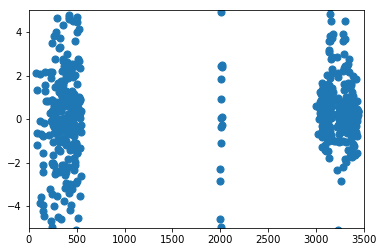

In [16]:
avg_loss=df_dayloss.groupby('station_id', as_index=False)['bike_loss'].mean()
plt.scatter(avg_loss.station_id, avg_loss.bike_loss,s=50)
axes = plt.gca()
axes.set_xlim([0,3500])
axes.set_ylim([-5,5])

In [17]:
small_sta_id=avg_loss[avg_loss.station_id<=2000]
print small_sta_id.describe()
large_sta_id=avg_loss[avg_loss.station_id>2000]
print large_sta_id.describe()

        station_id   bike_loss
count   291.000000  291.000000
mean    372.065292   -0.650924
std     147.551134    5.484967
min      72.000000  -49.677419
25%     290.000000   -1.903226
50%     376.000000    0.032258
75%     459.500000    1.274194
max    2000.000000   19.032258
        station_id   bike_loss
count   322.000000  322.000000
mean   3185.173913    0.605777
std     279.837081    3.272735
min    2001.000000  -11.806452
25%    3108.250000   -0.322581
50%    3238.500000    0.193548
75%    3349.750000    0.838710
max    3440.000000   33.818182


## Tune parameters --- Random Search & Grid Search

    1. Random Search: use random search to find good starting points, 
    2. Grid search: to zoom in and find the local optima (or close to it) for those good starting points

## Tune Parameters For Each Model-- Grid Search

Description:
Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

     1. Random Forest
     2. Lasso
     3. Ridge
     4. MLP
     
NOTE: GRID SEARCH WILL FILTER STATIONS THAT DESN'T MEET THE REQUIREMENT!(SAMPLE SIZE AT THAT STATION IS TOO SMALL TO CV)

In [318]:
len(set(df['start_stationid']))

606

In [339]:
# Delete station that has less than 20 samples (Not good for CV)
station_id_set = list(set(df_dayloss['station_id']))
useless_ids_index = []
for i in station_id_set:
    sample_size=len(df_dayloss[df_dayloss['station_id']==i])
    if sample_size < 20:
        useless_ids_index.append(station_id_set.index(i))
station_id_set=np.delete(station_id_set, useless_ids_index).tolist()
len(station_id_set)

597

In [411]:
station_id_set

[72,
 79,
 82,
 83,
 116,
 119,
 120,
 127,
 128,
 143,
 144,
 146,
 147,
 150,
 151,
 152,
 153,
 157,
 161,
 164,
 167,
 168,
 173,
 174,
 195,
 212,
 216,
 217,
 224,
 225,
 228,
 229,
 232,
 236,
 237,
 238,
 239,
 241,
 242,
 243,
 244,
 245,
 247,
 248,
 249,
 251,
 252,
 253,
 254,
 255,
 257,
 258,
 259,
 260,
 261,
 262,
 264,
 265,
 266,
 267,
 268,
 270,
 274,
 275,
 276,
 278,
 279,
 280,
 281,
 282,
 284,
 285,
 289,
 291,
 293,
 295,
 296,
 297,
 298,
 301,
 302,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 315,
 316,
 317,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 330,
 331,
 332,
 334,
 335,
 336,
 337,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 372,
 373,
 376,
 377,
 379,
 380,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 4

In [399]:
from sklearn.model_selection import GridSearchCV
parameter_box=[]
# RF:
reg_type = RandomForestRegressor()
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8, 9]}
  ]

# Lasso:
# reg_type = linear_model.Lasso()
# param_grid = [{'alpha':[1,0.1,0.01,0.001,0.0001,0,10.2,12.4,15,18]}]


#MLPRegressor -- Neural Network
# reg_type = MLPRegressor()
# param_grid = [{ 'hidden_layer_sizes':[(5),(50),(50,100),(100,50,100)],
#         'activation':['relu','identity', 'logistic', 'tanh'] ,
#         'max_iter':[50,200,500],
#         }]

def grid_search(reg_type,param_grid):
    grid_search = GridSearchCV(reg_type, param_grid, cv=5,
                               scoring='neg_mean_squared_error',n_jobs=-1)
    for i in station_id_set:
        a=df_dayloss[df_dayloss['station_id']==i]
        X=a.ix[:,5:16]
        y=a.ix[:,4]
        grid_search.fit(X, y)
        print grid_search.best_params_
        parameter_box.append(grid_search.best_params_)
grid_search(reg_type,param_grid)

{'max_features': 4, 'n_estimators': 10}
{'max_features': 9, 'n_estimators': 30}
{'max_features': 9, 'n_estimators': 30}
{'max_features': 2, 'n_estimators': 30}
{'max_features': 4, 'n_estimators': 30}
{'max_features': 2, 'n_estimators': 10}
{'max_features': 2, 'n_estimators': 30}
{'max_features': 8, 'n_estimators': 10}
{'max_features': 4, 'n_estimators': 30}
{'max_features': 6, 'n_estimators': 30}
{'max_features': 2, 'n_estimators': 10}
{'max_features': 2, 'n_estimators': 30}
{'max_features': 8, 'n_estimators': 10}
{'max_features': 8, 'n_estimators': 10}
{'max_features': 6, 'n_estimators': 30}
{'max_features': 2, 'n_estimators': 10}
{'max_features': 2, 'n_estimators': 10}
{'max_features': 6, 'n_estimators': 10}
{'max_features': 8, 'n_estimators': 3}
{'max_features': 6, 'n_estimators': 30}
{'max_features': 8, 'n_estimators': 3}
{'max_features': 2, 'n_estimators': 3}
{'max_features': 6, 'n_estimators': 10}
{'max_features': 8, 'n_estimators': 30}
{'max_features': 6, 'n_estimators': 3}
{'ma

In [383]:
Lasso_para_value = [x['alpha'] for x in parameter_box]


In [376]:
MLP_para_value1=[x['activation'] for x in parameter_box]
MLP_para_value2=[x['hidden_layer_sizes'] for x in parameter_box]
MLP_para_value3=[x['max_iter'] for x in parameter_box]


In [400]:
RF_para_value1=[x['max_features'] for x in parameter_box]
RF_para_value2=[x['n_estimators'] for x in parameter_box]

In [403]:
para_all=pd.concat([pd.DataFrame(Lasso_para_value),pd.DataFrame(MLP_para_value1),pd.DataFrame(MLP_para_value2),
                   pd.DataFrame(MLP_para_value3),pd.DataFrame(RF_para_value1),pd.DataFrame(RF_para_value2)],axis=1)

In [408]:
para_all.columns=['Lasso-Alpha','MLP-Activation','MLP-HiddenLayerSize','MLP-MaxIter','RF-MaxFeatures','RF-NEstimates']

In [420]:
print len(para_all)
print len(station_id_set)

597
597


In [418]:
para_all.index=station_id_set

In [419]:
# Tune Para Result:  For each station, each model.
para_all

,Lasso-Alpha,MLP-Activation,MLP-HiddenLayerSize,MLP-MaxIter,RF-MaxFeatures,RF-NEstimates
72,12.4,relu,50,200,4,10
79,1.0,tanh,50,200,9,30
82,1.0,relu,5,200,9,30
83,1.0,relu,50,50,2,30
116,15.0,relu,50,200,4,30
119,10.2,relu,50,500,2,10
120,1.0,logistic,5,500,2,30
127,1.0,tanh,"(50, 100)",500,8,10
128,10.2,relu,50,50,4,30
143,0.1,tanh,50,500,6,30


## Linear Regression 

    1. Linear regression for each station(December)
    2. Coff Analysis (Larger coff represents for larger effect of that variable)
    3. Significant test for each independent variable
    4. R^2 & accuracy of Linear Regression Model (When test data coming in)


# Cross Validation

1. CV for different models.
note: useless_id_index generated in linear regression CV

##  Cross Validation -- Linear Regression

In [422]:
LR_CV_score_set = []
LR_culmilative_set = []
# Count RMSE (Root Mean Squared Error) for every station 
for i in station_id_set:
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    linearReg = LinearRegression()
    mean_CV_score = math.sqrt(-(cross_val_score(linearReg, X, y, cv=10, scoring='neg_mean_squared_error').mean()))
    #print 'CV score for station %s is: '%i +str(mean_CV_score)
    LR_CV_score_set.append(mean_CV_score)
    LR_culmilative_set.append(np.mean(LR_CV_score_set))

print 'Mean Score of Cross Validation using Linear Regression is:' + str(np.mean(LR_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Linear Regression is:' + str(np.std(LR_CV_score_set))


Mean Score of Cross Validation using Linear Regression is:8.54144973593
Standard Deviation Score of Cross Validation using Linear Regression is:5.53159725278


## Cross Validation - Lasso

In [347]:
lasso_CV_score_set = []
lasso_culmilative_set = []
for i, j in zip(list(station_id_set), para_value):   # loop simultaneously
    a=df_dayloss[df_dayloss['station_id']==i]    
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    lasso = linear_model.Lasso(alpha=j)
    mean_CV_score = math.sqrt(-(cross_val_score(lasso, X, y,cv=5, scoring='neg_mean_squared_error').mean()))
    print 'CV score for station %s is: '%i +str(mean_CV_score)
    lasso_CV_score_set.append(mean_CV_score)
    lasso_culmilative_set.append(np.mean(lasso_CV_score_set))
print 'Mean Score of Cross Validation using Lasso Regression is: ' + str(np.mean(lasso_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Lasso Regression is: ' + str(np.std(lasso_CV_score_set))


CV score for station 72 is: 8.1761442964
CV score for station 79 is: 6.15258401544
CV score for station 82 is: 3.50933164243
CV score for station 83 is: 7.93287920665
CV score for station 116 is: 10.705575495
CV score for station 119 is: 2.20501391212
CV score for station 120 is: 3.56614435717
CV score for station 127 is: 6.15770090175
CV score for station 128 is: 6.81363524981
CV score for station 143 is: 6.86304338584
CV score for station 144 is: 3.64901513132
CV score for station 146 is: 8.27805317482
CV score for station 147 is: 6.03813047252
CV score for station 150 is: 12.4568341615
CV score for station 151 is: 14.1949760348
CV score for station 152 is: 7.80367320917
CV score for station 153 is: 16.6386386308
CV score for station 157 is: 5.33194302563
CV score for station 161 is: 8.49757962417
CV score for station 164 is: 9.9511892281
CV score for station 167 is: 6.28891278741
CV score for station 168 is: 14.9696374901
CV score for station 173 is: 11.6511517556
CV score for stati

In [309]:
print len(station_id_set)
print len(dict_value)

603
603


## Random Forest

    1. Importance of Each Feature
    2. Accuracy of Random Forest Model

## Cross Validation --- Random Forest

In [405]:
RF_CV_score_set = []
RF_culmilative_set = []
for i,j,k in zip(list(station_id_set),RF_para_value1,RF_para_value2):
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    rf = RandomForestRegressor(max_features=j,n_estimators=k)
    mean_CV_score = math.sqrt(-(cross_val_score(rf, X, y, cv=10, scoring='neg_mean_squared_error').mean()))
    print 'CV score for station %s is: '%i +str(mean_CV_score)
    RF_CV_score_set.append(mean_CV_score)
    RF_culmilative_set.append(np.mean(RF_CV_score_set))

CV score for station 72 is: 10.0044739992
CV score for station 79 is: 6.88756769365
CV score for station 82 is: 4.52242662656
CV score for station 83 is: 7.60985405137
CV score for station 116 is: 10.8605542625
CV score for station 119 is: 2.61667728236
CV score for station 120 is: 4.10668233047
CV score for station 127 is: 7.20654794845
CV score for station 128 is: 8.82929939337
CV score for station 143 is: 7.86940780606
CV score for station 144 is: 4.15331639019
CV score for station 146 is: 9.48784017104
CV score for station 147 is: 7.2194586593
CV score for station 150 is: 14.0165378512
CV score for station 151 is: 16.7082719589
CV score for station 152 is: 10.2812211949
CV score for station 153 is: 21.1949994102
CV score for station 157 is: 5.4914175462
CV score for station 161 is: 9.79176713896
CV score for station 164 is: 10.0382801779
CV score for station 167 is: 7.03937339383
CV score for station 168 is: 16.5536165904
CV score for station 173 is: 13.117815494
CV score for stati

In [406]:
print 'Mean Score of Cross Validation using Random Forest is: ' + str(np.mean(RF_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Random Forest is: ' + str(np.std(RF_CV_score_set))


Mean Score of Cross Validation using Random Forest is: 8.37967361665
Standard Deviation Score of Cross Validation using Random Forest is: 5.58708110836


## Cross Validation -- Neural Network

      1.  MLP: Multi-layer Perceptron

In [380]:
from sklearn.neural_network import MLPRegressor
MLP_CV_score_set = []
MLP_culmilative_set = []
for i,j,k,p in zip(list(station_id_set),MLP_para_value1,MLP_para_value2,MLP_para_value3):
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    y=a.ix[:,4]
    MLP = MLPRegressor(activation=j,hidden_layer_sizes=k,max_iter=p)
    mean_CV_score = math.sqrt(-(cross_val_score(MLP, X, y, cv=10, scoring='neg_mean_squared_error').mean()))
    print 'CV score for station %s is: '%i +str(mean_CV_score)
    MLP_CV_score_set.append(mean_CV_score)
    MLP_culmilative_set.append(np.mean(MLP_CV_score_set))

CV score for station 72 is: 8.35700220046
CV score for station 79 is: 6.38307800504
CV score for station 82 is: 4.37065527416
CV score for station 83 is: 7.44468101447
CV score for station 116 is: 10.5454103205
CV score for station 119 is: 2.23860791467
CV score for station 120 is: 3.7041987989
CV score for station 127 is: 6.41497209743
CV score for station 128 is: 7.59136127692
CV score for station 143 is: 7.30845302702
CV score for station 144 is: 3.96751724477
CV score for station 146 is: 8.68582538505
CV score for station 147 is: 5.85871047743
CV score for station 150 is: 15.1235364679
CV score for station 151 is: 13.2961113123
CV score for station 152 is: 7.62536465395
CV score for station 153 is: 16.8215178115
CV score for station 157 is: 5.33680738293
CV score for station 161 is: 8.17275300641
CV score for station 164 is: 10.145758121
CV score for station 167 is: 6.4708299642
CV score for station 168 is: 14.8305220494
CV score for station 173 is: 12.2555175076
CV score for stati

In [381]:
print 'Mean Score of Cross Validation using MLP is: ' + str(np.mean(MLP_CV_score_set))
print 'Standard Deviation Score of Cross Validation using MLP is: ' + str(np.std(MLP_CV_score_set))

Mean Score of Cross Validation using MLP is: 7.45055821364
Standard Deviation Score of Cross Validation using MLP is: 4.75385130278


## RF better than LR !

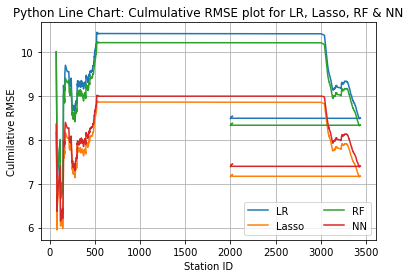

In [446]:
# The total RMASE is counted by average rmse of all stations
# For each model(LR & RF), the culmulative RMSE changes when new station coming in.
from pylab import *
t1 = LR_culmilative_set
t2 = lasso_culmilative_set
t3 = RF_culmilative_set
t4 = MLP_culmilative_set

s = station_id_set
plt.plot(s, t1, label='LR')
plt.plot(s, t2, label='Lasso')
plot(s, t3, label='RF')
plot(s, t4, label='NN')
xlabel('Station ID')
ylabel('Culmilative RMSE')
title('Python Line Chart: Culmulative RMSE plot for LR, Lasso, RF & NN')
grid(True)
plt.legend(loc='lower right',ncol=2)
plt.show()


## Testing

In [83]:
# =========== Preparing test data==========
df = pd.read_csv('201611-citibike-tripdata.csv')
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).replace(' ','').lower()
df.columns = [camel_to_snake(col) for col in df.columns]
try:
    df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df.start_time]
#except ValueError:
    #df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M') for x in df.start_time]
except ValueError:
     df['start_datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df.start_time]
df['start_day'] = [x.strftime('%Y-%m-%d') for x in df.start_datetime]
# =========== Group by date and station ===========
df['bikein'] = 1
df['bikeout'] = 1
df_bikeout = df.groupby(by=['start_stationid', 'start_day'])['bikeout'].count()
df_bikeout = pd.DataFrame(df_bikeout)
df_out = df_bikeout.reset_index(drop = False)
df_out.rename_axis({'start_stationid':'station_id'}, axis='columns', inplace=True)
df_bikein = df.groupby(by=['end_stationid', 'start_day'])['bikein'].count()
df_bikein = pd.DataFrame(df_bikein)
df_in = df_bikein.reset_index(drop = False)
df_in.rename_axis({'end_stationid':'station_id'}, axis='columns', inplace=True)
# =========== Bike loss per day for each station ===========
df_dayloss_test = df_out.merge(right=df_in, left_on=['station_id', 'start_day'], right_on=['station_id', 'start_day'],
                          how='outer')
df_dayloss_test = df_dayloss_test.sort_values(['station_id', 'start_day'])
df_dayloss_test = df_dayloss_test.fillna(0)
df_dayloss_test['bike_loss'] = df_dayloss_test['bikeout'] - df_dayloss_test['bikein']
print(df_dayloss_test[1:5])
df_wekday_index=pd.to_datetime(df_dayloss_test.start_day).dt.weekday   # index Monday=0, Sunday=6
df_dayloss_test['wek_index']=df_wekday_index
holiday = ['2016-01-01', '2016-01-18', '2016-02-12', '2016-02-15',
          '2016-05-08', '2016-05-30', '2016-06-19', '2016-07-04',
          '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24',
          '2016-12-26']
df_dayloss_test['holiday_idx'] = df_dayloss_test['start_day'].apply(lambda x: 1 if (x in holiday) else 0)

   station_id   start_day  bikeout
0          72  2016-11-01      133
1          72  2016-11-02      119
2          72  2016-11-03      146
3          72  2016-11-04      129
4          72  2016-11-05       92
   station_id   start_day  bikeout  bikein  bike_loss
1          72  2016-11-02    119.0   130.0      -11.0
2          72  2016-11-03    146.0   144.0        2.0
3          72  2016-11-04    129.0   108.0       21.0
4          72  2016-11-05     92.0   109.0      -17.0


In [84]:
def weather_Data(df_climate):
    dates = []
    maxtempF = []
    cltype = []
    each_day_weather_set = []
    dk = df_climate.drop_duplicates(['start_day'])

    for x in dk['start_day']:
        dates.append(x)
        api_str = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=c3e90d1cd020454594c203537172604&q=NY&date=' + x + '&format=json'       # print api_str
        time.sleep(0.02)
        r = requests.get(api_str)
        #print "request over"
        
        k = r.json()
        
        maxtempF.append(k['data']['weather'][0]['maxtempF'])

        size = len(k['data']['weather'][0]['hourly'])
        climate = []
        for l in range(size):
            climate.append(str(k['data']['weather'][0]['hourly'][l]['weatherDesc'][0].values()).split(" "))
        to_str = str(climate)
        r1=to_str.replace('[','').replace(']','').replace('"','').replace("u'",'').replace("'",'').replace(' ','')
        r2=r1.split(",")
        weather_condition_count=Counter(r2)
        most_common_weather=weather_condition_count.most_common(1)[0][0]
        each_day_weather_set.append(most_common_weather)
    new_dict = dict(zip(dates, maxtempF))
    new_dict2 = dict(zip(dates, each_day_weather_set))
    #print each_day_weather_set
    #print dates
    df_climate['High_temp'] = df_climate['start_day'].map(new_dict)
    df_climate['Climate_type'] = df_climate['start_day'].map(new_dict2)
    return df_climate
time.sleep(0.2)
weather_Data(df_dayloss_test)

,station_id,start_day,bikeout,bikein,bike_loss,wek_index,holiday_idx,High_temp,Climate_type
0,72,2016-11-01,133.0,127.0,6.0,1,0,60,Sunny
1,72,2016-11-02,119.0,130.0,-11.0,2,0,76,Sunny
2,72,2016-11-03,146.0,144.0,2.0,3,0,75,Overcast
3,72,2016-11-04,129.0,108.0,21.0,4,0,59,Clear
4,72,2016-11-05,92.0,109.0,-17.0,5,0,61,Clear
5,72,2016-11-06,96.0,90.0,6.0,6,0,57,Clear
6,72,2016-11-07,116.0,105.0,11.0,0,0,58,Clear
7,72,2016-11-08,128.0,137.0,-9.0,1,0,71,Sunny
8,72,2016-11-09,87.0,80.0,7.0,2,0,59,Light
9,72,2016-11-10,128.0,117.0,11.0,3,0,54,Partly


In [85]:
# Assign weekday = 0 and weekend = 1
df_dayloss_test['wek_index']=df_dayloss_test['wek_index'].replace([1,2,3,4],[0,0,0,0])
df_dayloss_test['wek_index']=df_dayloss_test['wek_index'].replace([5,6],[1,1])   # weekend

# Get Dummy Variables for 'Climate Type'
dummy_weather=pd.get_dummies(df_dayloss_test['Climate_type'])
df_dayloss_test = pd.concat([df_dayloss_test, dummy_weather], axis=1)

# Remove docks col 
#del df_dayloss['docks']

# Remove Climate_type col
del df_dayloss_test['Climate_type']


In [206]:
len(set(df_dayloss_test.station_id))


614

In [203]:
len(df_dayloss_test)


17779

In [97]:
training = df_dayloss
del training['Fog']
del training['Freezing']


In [101]:
training


,station_id,start_day,bikeout,bikein,bike_loss,wek_index,holiday_idx,High_temp,Clear,Light,Overcast,Partly,Sunny,rain
1,72,2016-12-02,92.0,85.0,7.0,0,0,46,0,0,0,0,1,0
2,72,2016-12-03,53.0,50.0,3.0,1,0,44,0,0,0,0,1,0
3,72,2016-12-04,47.0,60.0,-13.0,1,0,42,0,0,1,0,0,0
4,72,2016-12-05,78.0,62.0,16.0,0,0,49,0,1,0,0,0,0


## Predict Using Linear Regression

In [121]:
final_predict_set = []
for i,j in zip(station_id_set,station_id_set):
    a=training[training['station_id']==i]
    X=a.ix[:,5:14]
    Y=a.ix[:,4]# Assign features to be X and target to be Y.
    try:
        mdl = LinearRegression()
        mdl.fit(X,Y)
        b=df_dayloss_test[df_dayloss_test['station_id']==j]
        test_data=b.ix[:,5:14]
        final_predictions = mdl.predict(test_data)  # I just used trained X to test. 
        #print final_predictions
        final_predict_set.append(final_predictions)
        continue
    except:
        continue
LR_preditct = pd.DataFrame(final_predict_set)


In [217]:
LR_preditct=pd.DataFrame(LR_preditct)


30


In [199]:
one_col=pd.concat([LR_preditct[0],LR_preditct[1],LR_preditct[2],LR_preditct[3],LR_preditct[4],LR_preditct[5],LR_preditct[6],LR_preditct[7],LR_preditct[8],
                   LR_preditct[9],LR_preditct[10],LR_preditct[11],LR_preditct[12],LR_preditct[13],LR_preditct[14],LR_preditct[15],
                  LR_preditct[16],LR_preditct[17],LR_preditct[18],LR_preditct[19],LR_preditct[20],LR_preditct[21],LR_preditct[22],
                  LR_preditct[23],LR_preditct[24],LR_preditct[25],LR_preditct[26],LR_preditct[27],LR_preditct[28],
                  LR_preditct[29]],axis=0)

In [225]:
index_sorted=pd.DataFrame(one_col.sort_index(axis=0))

index_sorted.isnull().sum()
#len(index_sorted)-447
print index_sorted
len(index_sorted)


             0
0    10.134940
0     3.322200
0    10.137706
0    12.452184
0    11.509650
0    -2.630719
0     4.120918
0    11.720309
0    11.612316
0     3.910260
0     4.159879
0    10.559023
0    11.398891
0    -3.684012
0     3.067625
0    10.137706
0     2.577276
0     2.856967
0     1.593015
0     9.927047
0     6.135192
0     9.081647
0    -2.062611
0     7.188485
0     1.168933
0     9.824381
0    -1.499668
0    10.905909
0    -0.377343
0    13.505477
..         ...
606   1.670865
606   8.964931
606   9.534481
606  11.357044
606   6.284856
606   8.260940
606   3.781818
606   3.326178
606   8.147030
606  10.787493
606   3.264752
606  -2.291348
606   5.590930
606   2.528807
606   3.378662
606   3.212268
606  10.217942
606   8.488761
606   9.058311
606   3.895729
606  -1.839390
606   2.184091
606   6.096648
606   6.666198
606   0.994913
606   2.353471
606  -0.928109
606   3.574528
606   8.260940
606   2.240416

[18210 rows x 1 columns]


18210

In [221]:
sum(LR_preditct.isnull().sum())
    

447

## Predict Using Random Forest


In [102]:
final_predict_set = []
for i in station_id_set:
    a=training[training['station_id']==i]
    X=a.ix[:,5:14]
    y=a.ix[:,4]
    final_model = RandomForestRegressor(n_estimators=30,max_features=4)
    try:
        final_model.fit(X,y)   # Here fit the train model 
    except:
        continue



In [69]:
station_id_set = set(df_dayloss_test['station_id'])


In [119]:
final_predict_set = []
for j in station_id_set:
    b=df_dayloss_test[df_dayloss_test['station_id']==j]
    test_data=b.ix[:,5:14]
    final_predictions = final_model.predict(test_data)  # I just used trained X to test. 
    # print final_predictions
    final_predict_set.append(final_predictions)
    

ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

In [104]:
pd.DataFrame(final_predict_set)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
1,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
2,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
3,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
4,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
5,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
6,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
7,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
8,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,6.400000,...,-0.166667,1.400000,-0.233333,6.033333,2.833333,3.233333,-0.071111,15.966667,12.033333,8.366667
9,15.966667,15.966667,11.100000,10.933333,8.746667,8.746667,10.933333,15.966667,12.033333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Other Stuff

In [292]:
# Linear regession equations
station_id_set = list(set(df_dayloss['station_id']))
for i in station_id_set:
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    Y=a.ix[:,4]# Assign features to be X and target to be Y.
    try:
        mdl = LinearRegression()
        mdl.fit(X,Y)
        mdl.predict
        m = mdl.coef_
        b = mdl.intercept_
        #print 'y={}x+{}'.format(m,b)
    except:
        continue
        

In [53]:
#Feature Importance using RF(If needed) 
from sklearn.linear_model import RandomizedLasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
for i in station_id_set:
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:16]
    y=a.ix[:,4]# Assign features to be X and target to be Y.
#     rf = RandomForestRegressor(n_estimators=30)
#     rf.fit(X, y)
#     print rf.feature_importances_
#     lr = LinearRegression()
#     rfe = RFE(lr, n_features_to_select=1)
#     rfe.fit(X,y)
    rlasso = RandomizedLasso(alpha=0.1)
    try:
        rlasso.fit(X, y)
    except:
        continue


#     rfe = RFE(rf, n_features_to_select=1)
#     rfe.fit(X,Y）


In [54]:
varible_names=list(df_dayloss)[5:]


In [58]:
# from sklearn.linear_model import RandomizedLasso
# #Feacture Importance continue
names = varible_names
names = np.array(names)
#sorted(zip(names, rf.feature_importances_),key=lambda x: x[1],reverse=True)
print 'feature imoirtance rank using lasso_score is: '
sorted(zip(names, rlasso.scores_),key=lambda x: x[1],reverse=True)
#print sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))

feature imoirtance rank using lasso_score is: 


[('wek_index', 0.97999999999999998),
 ('Sunny', 0.86499999999999999),
 ('Partly', 0.70499999999999996),
 ('Clear', 0.57499999999999996),
 ('High_temp', 0.34999999999999998),
 ('holiday_idx', 0.29999999999999999),
 ('Light', 0.28999999999999998),
 ('Overcast', 0.23499999999999999),
 ('Freezing', 0.22),
 ('rain', 0.11),
 ('Fog', 0.01)]

### training data split

In [405]:
dayloss_72 =df_dayloss[df_dayloss['station_id'] == 79]

In [53]:
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
# training data split
X = dayloss_72[['wek_index','holiday_idx','docks']]
y = dayloss_72['bike_loss']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)
#y_train, y_test = cross_validation(y, test_size = 0.25, random_state = 123)
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()
X_train[1:5]

,wek_index,holiday_idx,docks
1,4,0,34.0
2,5,0,34.0
3,6,0,34.0
4,0,0,34.0


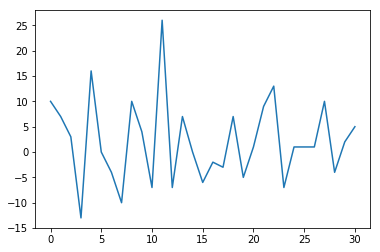

In [55]:
plt.plot(dayloss_72.index, dayloss_72.bike_loss)

### Lasso

In [56]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
import numpy as np

In [57]:
import math
def RMSPE(y, y_pred):
    return math.sqrt( ((1- y_pred / y)**2).mean() )

In [58]:
def test_lasso(alphas):
    scores_lasso = []
    kf = KFold(n_splits=10, random_state = 123)
    
    for alpha in alphas:
        lasso = Lasso(alpha)
        for train, val in kf.split(X_train):
            score_cv = []
            y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
            score_cv.append(RMSPE(y_train.values[val], y_pred))
            score = np.mean(score_cv)
        scores_lasso.append(score)
    
    plt.figure(figsize=(14,8))
    cv_lasso = pd.Series(scores_lasso, index = alphas)
    cv_lasso.plot(title = "Validation - Lasso")
    plt.xlabel("alpha")
    plt.ylabel("RMSPE")
    print(cv_lasso.argmin())

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


20.0


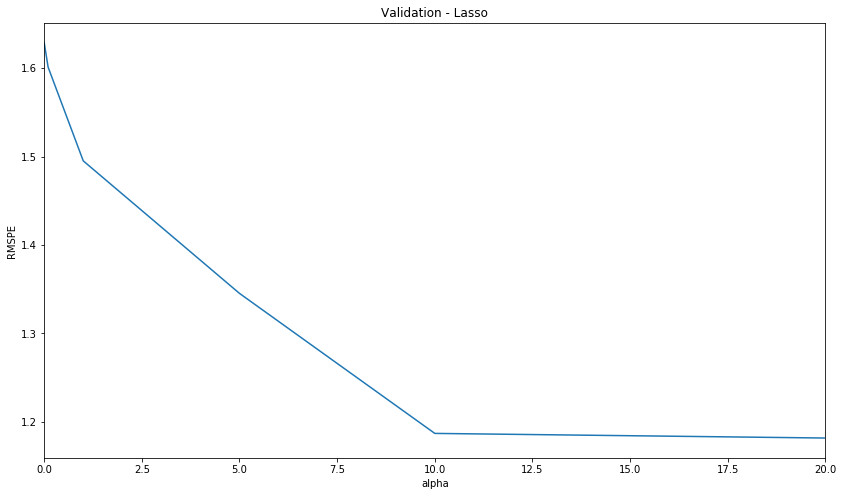

In [75]:
alphas = [1e-4, 1e-3,1e-2, 0.1, 1, 5, 10, 20]
test_lasso(alphas)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


12


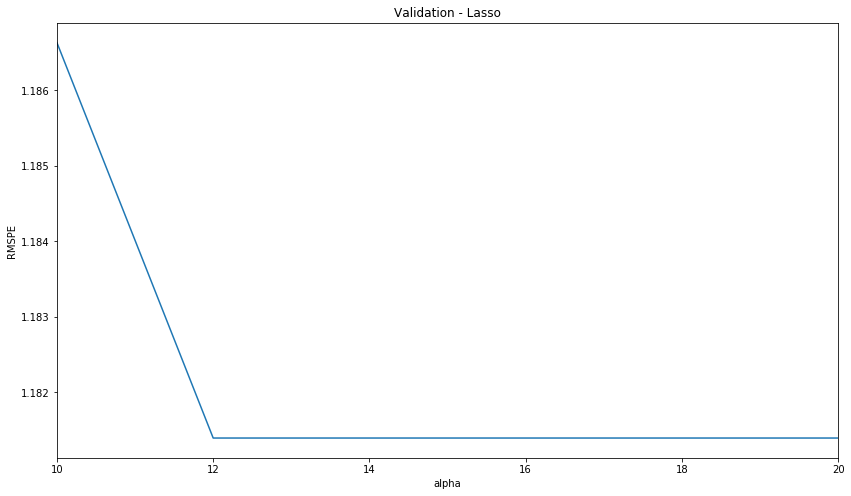

In [76]:
alphas = [10, 12, 14, 18, 20]
test_lasso(alphas)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


10.5


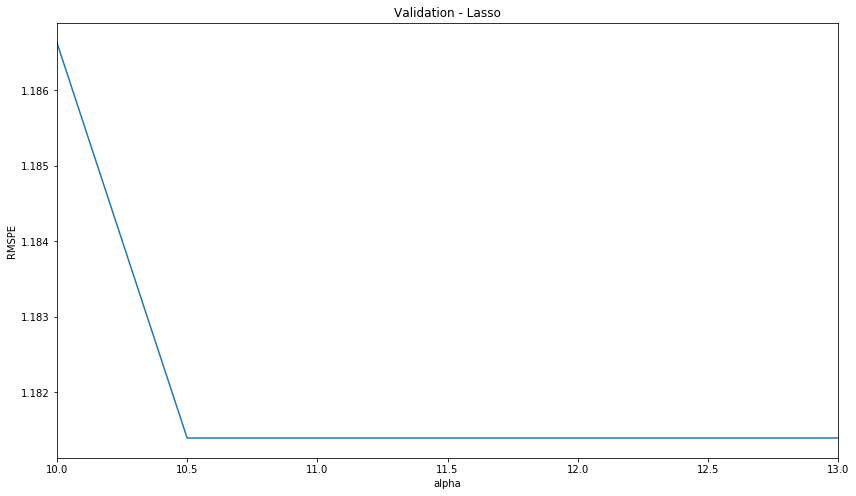

In [77]:
alphas = [10, 10.5, 11, 11.25, 11.5, 11.75, 12, 12.25, 12.5, 13]
test_lasso(alphas)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


10.2


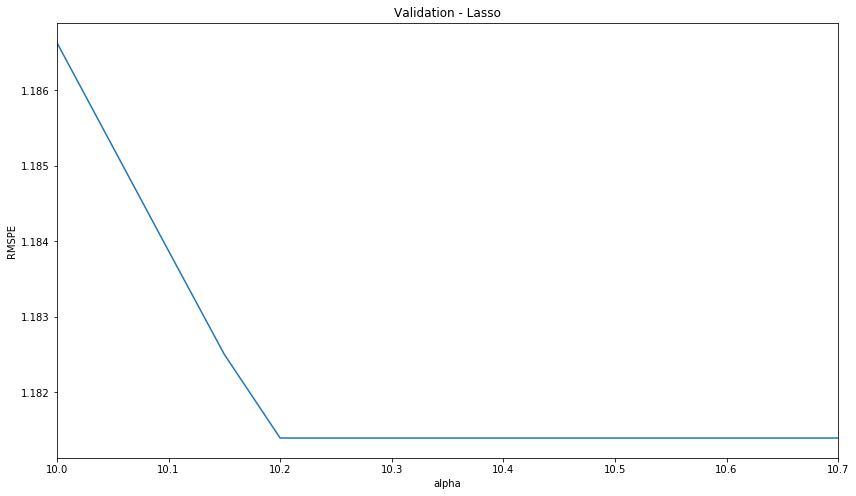

In [78]:
alphas = [10, 10.10,10.15, 10.20, 10.25, 10.30,10.40,10.55,10.7]
test_lasso(alphas)

In [79]:
lasso = Lasso(alpha=10.2)
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)
    
for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


In [80]:
# prediction of bike loss of station 72
y_pred

array([ 2.33333333,  2.33333333])